In [1]:
%reset -f

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import TransformedTargetRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import Helpers
from xgboost import XGBRegressor

#import cleaned_data.csv to pandas.

data = pd.read_csv('cleaned_data.csv')

data = data.sample(frac=0.1, random_state=1)  # `random_state` ensures reproducibility


X_train, X_test, y_train, y_test = Helpers.split_data(data)

gradient_monitor = Helpers.GradientMonitor()


C:\Users\Christoffer\AppData\Local\Temp\ipykernel_21212\1759661001.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,EstimatedSalary,Geography,Gender
72388,698,27.0,125427.37,2,1,27654.44,Spain,Male
109204,617,31.0,127631.62,1,1,159416.41,France,Female
65452,748,41.0,86569.76,1,1,125898.49,France,Male
54826,598,38.0,202904.64,1,1,6921.49,Spain,Male
101693,726,56.0,107720.64,1,1,89566.74,Germany,Female
...,...,...,...,...,...,...,...,...
54587,775,67.0,118897.10,2,0,26362.40,Germany,Female
75025,684,37.0,122214.00,2,1,184524.74,Germany,Female
82440,709,39.0,129068.54,2,1,187929.43,France,Female
25980,729,40.0,117866.92,1,1,104016.61,Germany,Male


In [8]:
# Define the features that need encoding and those that don't
categorical_features = ['Geography', 'Gender']
numerical_features = ['CreditScore', 'Age', 'Balance', 'NumOfProducts','HasCrCard']


In [19]:
# Create transformers for the pipeline
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Adding RobustScaler for numerical features
numerical_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

def create_model(input_dim, learning_rate):
    model = Sequential()
    model.add(Dense(612, input_shape=(input_dim,), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2058, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1, activation='linear'))  # Using linear output for regression
    # Configure the model with the Adam optimizer and a custom learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model



In [24]:
# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

reduce_lr = ReduceLROnPlateau(patience=200, monitor="loss")

callbacks = [reduce_lr]

# Define Keras model in the pipeline
model = KerasRegressor(build_fn=lambda: create_model(input_dim=preprocessor.transform(X_train).shape[1], learning_rate=0.0015),
                       epochs=10000, batch_size=512, verbose=2, callbacks=callbacks)

# Wrap the Keras model with target transformation
target_scaler = RobustScaler()
tt_reg = TransformedTargetRegressor(regressor=model, transformer=target_scaler)





In [25]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [26]:
# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', tt_reg)
])



# Apply the pipeline to the data
pipeline.fit(X_train, y_train, regressor__callbacks=callbacks)


Epoch 1/10000


E:\DataSpellProjects\SKFSkraper\venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
E:\DataSpellProjects\SKFSkraper\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 - 5s - 273ms/step - loss: 0.9841 - learning_rate: 0.0015
Epoch 2/10000
20/20 - 4s - 195ms/step - loss: 0.3770 - learning_rate: 0.0015
Epoch 3/10000
20/20 - 4s - 195ms/step - loss: 0.3765 - learning_rate: 0.0015
Epoch 4/10000
20/20 - 4s - 190ms/step - loss: 0.3761 - learning_rate: 0.0015
Epoch 5/10000
20/20 - 4s - 218ms/step - loss: 0.3765 - learning_rate: 0.0015
Epoch 6/10000
20/20 - 4s - 204ms/step - loss: 0.3757 - learning_rate: 0.0015
Epoch 7/10000
20/20 - 5s - 230ms/step - loss: 0.3764 - learning_rate: 0.0015
Epoch 8/10000
20/20 - 4s - 212ms/step - loss: 0.3774 - learning_rate: 0.0015
Epoch 9/10000
20/20 - 4s - 217ms/step - loss: 0.3752 - learning_rate: 0.0015
Epoch 10/10000
20/20 - 4s - 216ms/step - loss: 0.3757 - learning_rate: 0.0015
Epoch 11/10000
20/20 - 4s - 223ms/step - loss: 0.3752 - learning_rate: 0.0015
Epoch 12/10000
20/20 - 4s - 211ms/step - loss: 0.3748 - learning_rate: 0.0015
Epoch 13/10000
20/20 - 4s - 224ms/step - loss: 0.3751 - learning_rate: 0.0015
Epoch 14/

KeyboardInterrupt: 

In [27]:
# Predict and evaluate
from sklearn.metrics import mean_squared_error
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

5/5 - 0s - 85ms/step
Mean Squared Error: 4384531182.875447


5/5 - 0s - 37ms/step


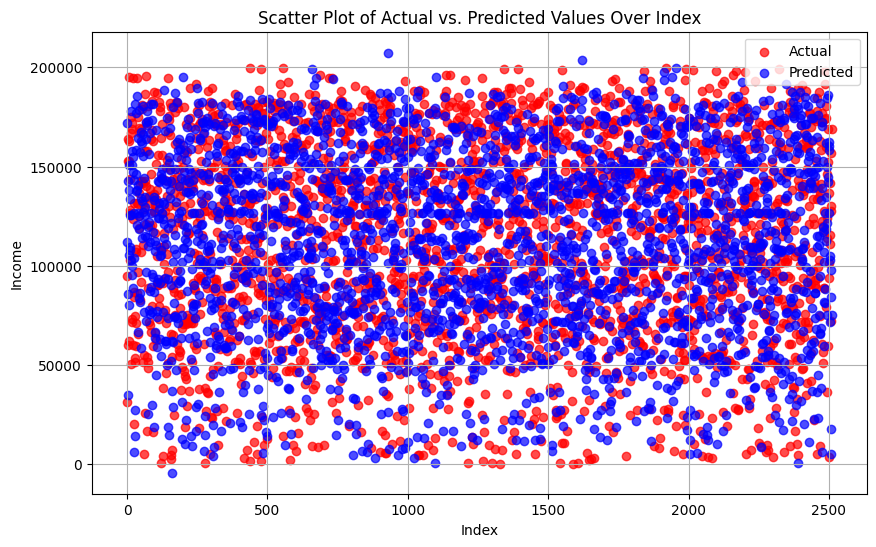

In [30]:
import matplotlib.pyplot as plt

# Predict using the pipeline
y_pred = pipeline.predict(X_test)

# Create indices for x-axis
index = range(len(y_test))

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(index, y_test, color='red', label='Actual', alpha=0.7)
plt.scatter(index, y_pred, color='blue', label='Predicted', alpha=0.7)

plt.title('Scatter Plot of Actual vs. Predicted Values Over Index')
plt.xlabel('Index')
plt.ylabel('Income')
plt.legend()
plt.grid(True)
plt.show()


5/5 - 0s - 40ms/step


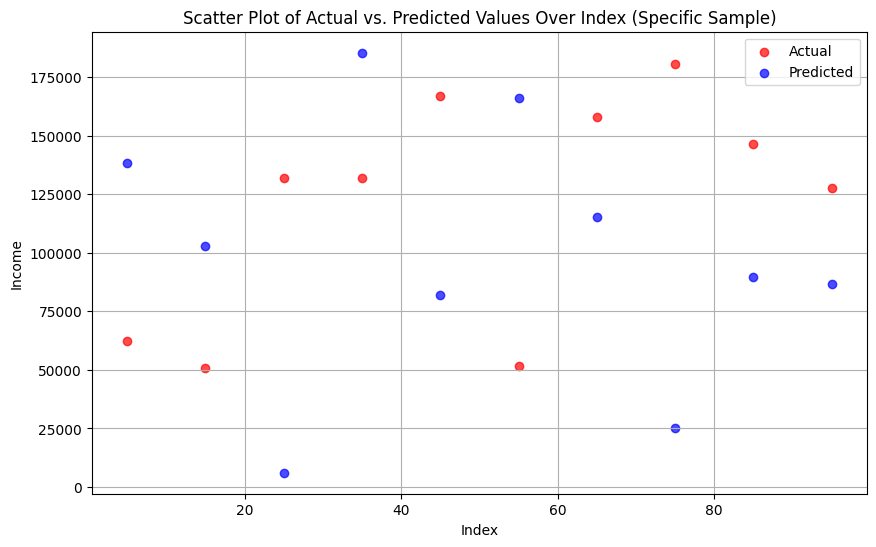

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Predict using the pipeline
y_pred = pipeline.predict(X_test)

# Define specific indices
specific_indices = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]

# Create a subset of the actual and predicted values
y_test_sampled = y_test.iloc[specific_indices]
y_pred_sampled = y_pred[specific_indices]

# Create the scatter plot for the specific sample
plt.figure(figsize=(10, 6))
plt.scatter(specific_indices, y_test_sampled, color='red', label='Actual', alpha=0.7)
plt.scatter(specific_indices, y_pred_sampled, color='blue', label='Predicted', alpha=0.7)

plt.title('Scatter Plot of Actual vs. Predicted Values Over Index (Specific Sample)')
plt.xlabel('Index')
plt.ylabel('Income')
plt.legend()
plt.grid(True)
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


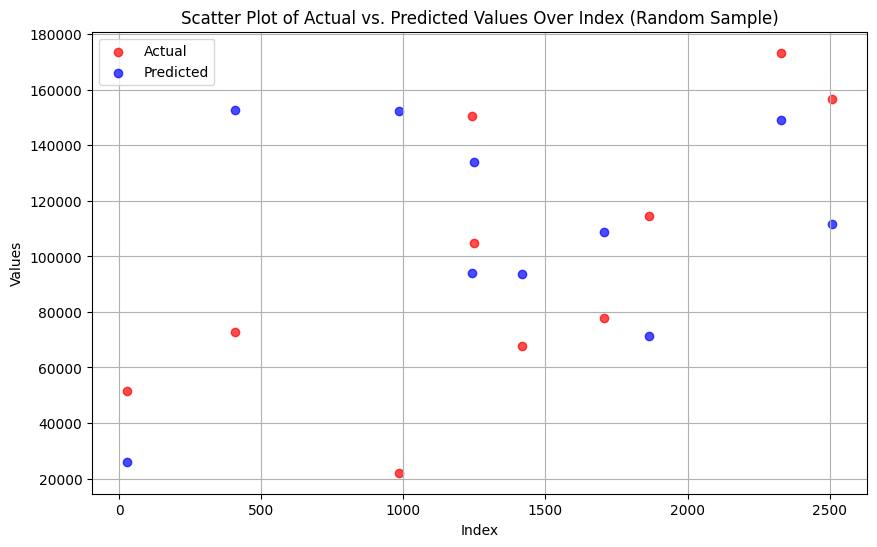

In [14]:
import numpy as np

# Predict using the pipeline
y_pred = pipeline.predict(X_test)

# Number of random samples to select
n_samples = 10

# Create random indices
random_indices = np.random.choice(range(len(y_test)), size=n_samples, replace=False)

# Create a subset of the actual and predicted values
y_test_sampled = y_test.iloc[random_indices]
y_pred_sampled = y_pred[random_indices]

# Create the scatter plot for the random sample
plt.figure(figsize=(10, 6))
plt.scatter(random_indices, y_test_sampled, color='red', label='Actual', alpha=0.7)
plt.scatter(random_indices, y_pred_sampled, color='blue', label='Predicted', alpha=0.7)

plt.title('Scatter Plot of Actual vs. Predicted Values Over Index (Random Sample)')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
import pickle

pickle.dump(model, open('pipeline.pkl', 'wb'))

PicklingError: Can't pickle <function <lambda> at 0x000002B2DCC43BA0>: attribute lookup <lambda> on __main__ failed